In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Zbiór danych

Pochodzi z platformy Kaggle: https://www.kaggle.com/datasets/datasnaek/mbti-type .

In [47]:
#każdy rząd składa się z typu osobowości i 50 ostatnich postów
df = pd.read_csv('mbti_1.csv', sep=',')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [48]:
#16 typów osobowości - nazwy klas
types = df.type.unique().tolist()
print(types)

#dodanie kolumny z klasami wyrażonymi liczbami (0 - 15)
df['class_no'] = df.apply(lambda x: types.index(x['type']), axis=1)

df

['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP', 'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']


,type,posts,class_no
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,2
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",3
4,ENTJ,'You're fired.|||That's another silly misconce...,4
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,8
8671,ENFP,'So...if this thread already exists someplace ...,7
8672,INTP,'So many questions when i do these things. I ...,2
8673,INFP,'I am very conflicted right now when it comes ...,6


In [49]:
#słownik odkodowujący
idx_to_type = {}
for i, t in enumerate(types): idx_to_type[i] = t

idx_to_type

{0: 'INFJ',
 1: 'ENTP',
 2: 'INTP',
 3: 'INTJ',
 4: 'ENTJ',
 5: 'ENFJ',
 6: 'INFP',
 7: 'ENFP',
 8: 'ISFP',
 9: 'ISTP',
 10: 'ISFJ',
 11: 'ISTJ',
 12: 'ESTP',
 13: 'ESFP',
 14: 'ESTJ',
 15: 'ESFJ'}

In [50]:
#zamiana separatora postów na zwykłą spację
df['posts_merged'] = df['posts'].str.replace(pat = '|||', repl = ' ')

In [51]:
df.head()

,type,posts,class_no,posts_merged
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...
1,ENTP,'I'm finding the lack of me in these posts ver...,1,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...,2,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",3,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...,4,'You're fired. That's another silly misconcept...


### Rozpakowanie postów

Każdy z wierszy zawiera wewnątrz 50 postów. Nie rozdzielamy ich, są już złączone w jeden długi tekst.

In [52]:
#usunięcie rozdzielonej kolumny
df = df.drop(columns = ['posts'])

In [53]:
#zmiana typów zmiennych
df = df.astype({'type':'string', 'posts_merged':'string'})

In [54]:
df.head()

,type,class_no,posts_merged
0,INFJ,0,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...
1,ENTP,1,'I'm finding the lack of me in these posts ver...
2,INTP,2,'Good one _____ https://www.youtube.com/wat...
3,INTJ,3,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,4,'You're fired. That's another silly misconcept...


### Czyszczenie tekstu i ekstrakcja cech

Tokenizacja

In [55]:
#zmiejszenie liter i rozdzielenie ciągów znaków na listy słów/cząstek
# df_test['post_words'] = df_test.apply(lambda x: word_tokenize(x['post'].lower()), axis=1)
# df_train['post_words'] = df_train.apply(lambda x: word_tokenize(x['post'].lower()), axis=1)

#zmiejszenie liter i rozdzielenie ciągów znaków na listy słów/cząstek - ten tokenizer nie rozdziela na "he" + "'s" i zachowuje całe emotki oraz hashtagi
tweet_tokenizer = TweetTokenizer()
df['post_words'] = df.apply(lambda x: tweet_tokenizer.tokenize(x['posts_merged'].lower()), axis=1)

Słowa bez znaczenia

In [56]:
#usuwanie słów bez znaczenia ('stopwords')
nltk.download('stopwords')

#wszystkie są pisane małymi literami
#uwaga - usunięte będą zarówno słowa "have/has" jak i skrócone wersje "i've/he's" - jeśli typy osobowości znajdują rozróżnienie na tym polu to badanie będzie ograniczone
stopwords.words('english')[:15], stopwords.words('english')[-15:]

#co istotne - zbiór zawiera zarówno wersje słów "w całości" jak i "w częściach" (dowolność tokenizacji): ‘won’, ‘t’, “won’t”
#nie zawiera cząstek, które otrzymamy używając word_tokenize biblioteki NLTK - "'s"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours'],
 ["mustn't",
  'needn',
  "needn't",
  'shan',
  "shan't",
  'shouldn',
  "shouldn't",
  'wasn',
  "wasn't",
  'weren',
  "weren't",
  'won',
  "won't",
  'wouldn',
  "wouldn't"])

In [57]:
stop_set = set(stopwords.words('english'))

#problem
"i'm" in stop_set, "i've" in stop_set, "i" in stop_set, "have" in stop_set, "am" in stop_set, "im" in stop_set, "m" in stop_set, "'m" in stop_set
#należy rozdzielić słowa z uwzględnieniem apostrofów

(False, False, True, True, True, False, True, False)

In [58]:
df['post_split'] = df.apply(lambda x: [word.split("'") for word in x.post_words], axis=1)

In [59]:
#spłaszczanie list

df['post_flatten'] = df.apply(lambda x: [word for sublist in x.post_split for word in sublist], axis=1)

In [60]:
#usuwanie słów bez znaczenia
df['post_no_stopwords'] = df.apply(lambda x: [word for word in x.post_flatten if word not in stop_set], axis=1)

In [61]:
#zamiana linków na słowo kluczowe
def replace_URL(str):
    return re.sub(r"http\S+", "[LINK]", str)

df['post_links'] = df.apply(lambda x: [replace_URL(word) for word in x.post_no_stopwords], axis=1)

Emotki

In [62]:
#zamiana powszechnych emoji na słowo kluczowe (emotki bez liczb + emotka serce)

def delete_foreign_emoji(str):
    return re.sub(r"사랑", "", str)

def replace_emojis(str):
    str = re.sub(r"\A[^\sa-zA-Z0-9_.]{2,}\Z", "[EMOJI]", str)
    str = re.sub(r"\A[:;][pd]\Z", "[EMOJI]", str)
    str = re.sub(r"<3", "[EMOJI]", str)
    str = re.sub(r"❤", "[EMOJI]", str)
    return str

df['post_emojis'] = df.apply(lambda x: [replace_emojis(delete_foreign_emoji(word)) for word in x.post_links], axis=1)

Interpunkcja

In [63]:
#flagowanie istotnych znaków interpunkcyjnych (kropek, wielokropka, wykrzykników, pytajników, bo mogą być znaczące dla analizy)
def replace_punctuation(str):
    str = re.sub(r"\A\.\.\.\Z", "[ELLIPSIS]", str)
    str = re.sub(r"\A\?\Z", "[QUESTION_MARK]", str)
    str = re.sub(r"\A!\Z", "[EXCLAMATION_MARK]", str)
    str = re.sub(r"\A\.\Z", "[PERIOD]", str)
    return str

df['post_punctuation_flags'] = df.apply(lambda x: [replace_punctuation(word) for word in x.post_emojis], axis=1)

In [64]:
#usuwanie przypadkowych i nieznaczących zbiorów znaków
def delete_punctuation(str):
    if(re.search(r"\A[^a-zA-Z0-9]+\Z", str)):
        if str not in ["[LINK]", "[EMOJI]", "[ELLIPSIS]", "[QUESTION_MARK]", "[EXCLAMATION_MARK]", "[PERIOD]"]:
            str = re.sub(r"\A[^a-zA-Z0-9_]+\Z", "", str)
    return str

df['post_punctuation_cleaned'] = df.apply(lambda x: [delete_punctuation(word) for word in x.post_punctuation_flags], axis=1)

Liczby

In [65]:
#flagowanie czystych liczb (ich dokładne wartości nie mają znaczenia, a poszerzą słownik)
def replace_numbers(str):
    return re.sub(r"\A[0-9]+\Z", "[NUMBER]", str)

df['post_numbers'] = df.apply(lambda x: [replace_numbers(word) for word in x.post_punctuation_cleaned], axis=1)

Hashtagi

In [66]:
def replace_hashtags(str):
    return re.sub(r"#", "", str)

df['post_no_hashtags'] = df.apply(lambda x: [replace_hashtags(word) for word in x.post_numbers], axis=1)

Usuwanie pustych elementów

In [67]:
df['post_cleaned'] = df.apply(lambda x: list(filter(None, x.post_no_hashtags)), axis=1)

### Podział danych

In [68]:
from copy import deepcopy

#wycinki ramek danych (kopie głębokie) - jedynie wyczyszczone dane oraz numeryczne oznaczenia klas

print(df.columns)

df_cols = df[["type", "class_no", "post_cleaned"]].copy(deep=True)

Index(['type', 'class_no', 'posts_merged', 'post_words', 'post_split',
       'post_flatten', 'post_no_stopwords', 'post_links', 'post_emojis',
       'post_punctuation_flags', 'post_punctuation_cleaned', 'post_numbers',
       'post_no_hashtags', 'post_cleaned'],
      dtype='object')


In [69]:
from sklearn.model_selection import train_test_split

# Split 80/20
df_train, df_test = train_test_split(df_cols, test_size=0.2, random_state=0, shuffle=True, stratify=df.type)

In [26]:
# X_train = df_train.posts_merged
# Y_train = df_train.class_no

# X_test = df_test.posts_merged
# Y_test = df_test.class_no

### Modelowanie - BERT

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [27]:
# !pip install tf-models-official

In [28]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

c:\Users\marta\anaconda3\envs\mgr\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\marta\anaconda3\envs\mgr\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

In [29]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [33]:
# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [34]:
# text_test = [df_train.post_cleaned[0]]
# text_preprocessed = bert_preprocess_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

In [35]:
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [36]:
# bert_results = bert_model(text_preprocessed)

# print(f'Loaded BERT: {tfhub_handle_encoder}')
# print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

In [37]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(16, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [39]:
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# # print(tf.sigmoid(bert_raw_result))
# bert_raw_result

In [40]:
print(classifier_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [41]:
classifier_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [70]:
df_test['post_joined'] = df_test.apply(lambda x: " ".join(x.post_cleaned), axis=1)
df_train['post_joined'] = df_train.apply(lambda x: " ".join(x.post_cleaned), axis=1)

In [71]:
df_train = df_train.rename(columns={'class_no': 'label', 'post_joined': 'text'})
df_test = df_test.rename(columns={'class_no': 'label', 'post_joined': 'text'})

In [72]:
df_train.text

2710    care others tattoos would never get tattoo [PE...
5029    momento mori [PERIOD] often make mistake watch...
3413    thoughts erik better known phantom opera infp ...
2166    said zero flexibility little time dating [PERI...
8288    glad liked [PERIOD] also heard quote [PERIOD] ...
                              ...                        
2236    somewhere around 50-75 posts never get submitt...
2657    yeah er fortunately bit logical waste time use...
115     [LINK] callout anyone wants [EMOJI] feel free ...
2025    einstein alpha nt way [PERIOD] likely lii-ne s...
5070    someone cheer really bad day [PERIOD] missing ...
Name: text, Length: 6940, dtype: object

In [73]:
ds = tf.data.Dataset.from_tensor_slices((df_train.loc[:, 'text'], tf.one_hot(df_train.loc[:, 'label'], 16)))
ds_test = tf.data.Dataset.from_tensor_slices((df_test.loc[:, 'text'], tf.one_hot(df_test.loc[:, 'label'], 16)))

In [74]:
ds.take(0).element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(16,), dtype=tf.float32, name=None))

In [75]:
ds = ds.batch(8)
ds_test = ds_test.batch(8)

In [76]:
ds.take(0).element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))

In [77]:
AUTOTUNE = tf.data.AUTOTUNE
ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

In [78]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=ds, validation_data=ds_test, epochs=20)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/20


868/868 [==============================] - 113s 122ms/step - loss: 2.5270 - categorical_accuracy: 0.1641 - val_loss: 2.4581 - val_categorical_accuracy: 0.1695
Epoch 2/20
868/868 [==============================] - 105s 121ms/step - loss: 2.5034 - categorical_accuracy: 0.1633 - val_loss: 2.4758 - val_categorical_accuracy: 0.1695
Epoch 3/20
868/868 [==============================] - 103s 118ms/step - loss: 2.4857 - categorical_accuracy: 0.1709 - val_loss: 2.4547 - val_categorical_accuracy: 0.1695
Epoch 4/20
868/868 [==============================] - 102s 117ms/step - loss: 2.4798 - categorical_accuracy: 0.1768 - val_loss: 2.4575 - val_categorical_accuracy: 0.1695
Epoch 5/20
868/868 [==============================] - 100s 116ms/step - loss: 2.4774 - categorical_accuracy: 0.1705 - val_loss: 2.4617 - val_categorical_accuracy: 0.1695
Epoch 6/20
868/868 [==============================] - 106s 122ms/step - loss: 2.4705 - categorical_accuracy: 0.1659 - val_loss: 2.4682 - val_categorical_accuracy

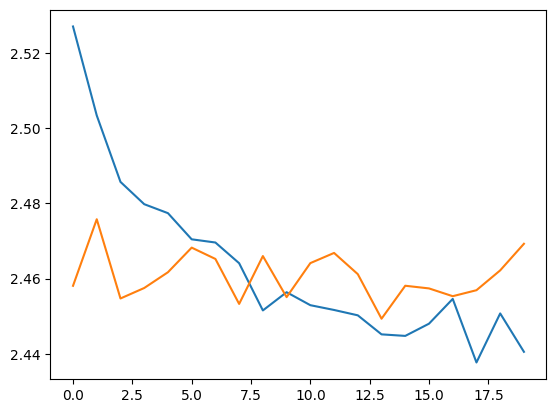

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

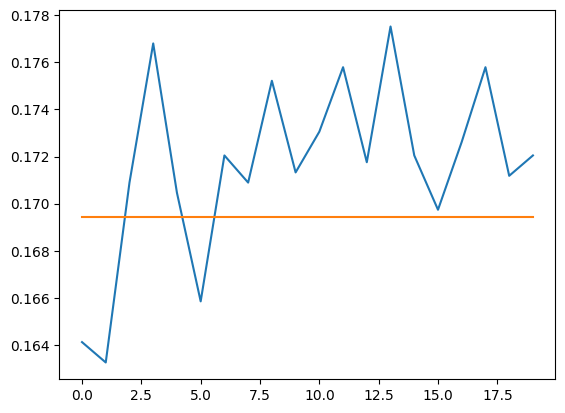

In [80]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])